In [2]:
# Rileggi il CSV con separatore '\t' e encoding utf-16 per ottenere le colonne corrette
import pandas as pd
df = pd.read_csv('balance backtest from 2020 eurchf.csv', encoding='utf-16', sep='\t')
df.head()

,<DATE>,<BALANCE>,<EQUITY>,<DEPOSIT LOAD>
0,2020.01.01 00:00,10000.00,10000.00,0.0000
1,2020.01.01 23:33,10000.29,9996.61,0.0000
2,2020.01.02 01:50,10000.29,10000.29,33.3323
3,2020.01.02 01:50,10000.29,10000.29,0.0000
4,2020.01.02 16:34,10002.02,10000.08,0.0000


In [3]:
# Mostra i nomi delle colonne e i tipi di dato
print(df.columns)
print(df.dtypes)

Index(['<DATE>', '<BALANCE>', '<EQUITY>', '<DEPOSIT LOAD>'], dtype='object')
<DATE>             object
<BALANCE>         float64
<EQUITY>          float64
<DEPOSIT LOAD>    float64
dtype: object


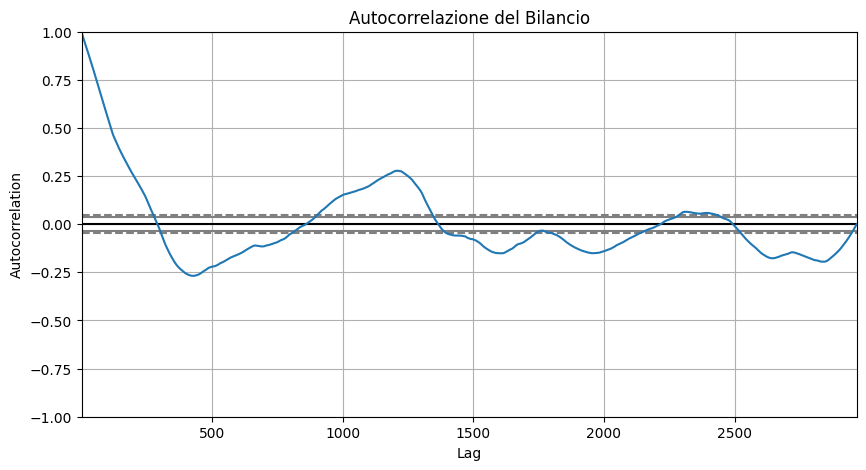

In [4]:
# Plot dell'autocorrelazione della colonna <BALANCE>
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10,5))
autocorrelation_plot(df['<BALANCE>'])
plt.title('Autocorrelazione del Bilancio')
plt.show()

## Interpretazione del grafico di autocorrelazione
L’autocorrelazione del bilancio mostra come i valori futuri del bilancio siano correlati con i valori passati. Dal grafico ottenuto:
- L’autocorrelazione è molto alta per i primi lag (vicino a 1), il che è normale per una serie cumulativa come il bilancio: ogni valore dipende fortemente dal precedente.
- L’autocorrelazione scende rapidamente e oscilla intorno allo zero per lag più alti, con alcune oscillazioni positive e negative.
- Le bande tratteggiate rappresentano l’intervallo di confidenza: dove la linea blu esce da queste bande, l’autocorrelazione è statisticamente significativa.
**Interpretazione pratica:**
- Il bilancio della strategia non mostra autocorrelazione significativa a lag elevati, quindi non ci sono pattern di dipendenza a lungo termine evidenti.
- L’alta autocorrelazione iniziale è tipica di una serie cumulativa e non indica necessariamente inefficienze o pattern sfruttabili.
- Se la linea blu restasse fuori dalle bande per molti lag, potrebbe indicare pattern o problemi strutturali nella strategia.
In sintesi: il bilancio segue un comportamento atteso per una equity line di trading, senza evidenti autocorrelazioni anomale a lungo termine. Se vuoi analizzare la serie dei rendimenti (differenze giornaliere), potresti trovare informazioni più utili sulla dipendenza temporale della strategia.